In [ ]:
from google.colab import files
uploaded = files.upload()  # upload fer2013.zip


Saving fer2013.zip to fer2013.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile("fer2013.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")


In [ ]:
print(os.listdir('/content/'))

['.config', 'fer2013.zip', 'train', 'test', 'sample_data']


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 48s 96ms/step - accuracy: 0.2725 - loss: 1.7915 - val_accuracy: 0.3770 - val_loss: 1.6180
Epoch 2/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.3339 - loss: 1.6708 - val_accuracy: 0.3792 - val_loss: 1.5949
Epoch 3/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.3496 - loss: 1.6451 - val_accuracy: 0.3807 - val_loss: 1.5781
Epoch 4/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.3472 - loss: 1.6417 - val_accuracy: 0.3973 - val_loss: 1.5657
Epoch 5/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 37s 83ms/step - accuracy: 0.3552 - loss: 1.6309 - val_accuracy: 0.3899 - val_loss: 1.5687
Epoch 6/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 38s 84ms/step - accuracy: 0.3607 - loss: 1.6152 - val_accuracy: 0.3899 - val_loss: 1.5691
Epoch 7/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.3726 - loss: 1.6108 - val_accuracy: 0.3962 - val_loss: 1.5562
Epoch 8/30
449/449 ━━━━━━━━━━━━━━━━━━━━ 38s 85ms/step - accuracy: 0.3736 - loss: 1.6038 - val_accurac

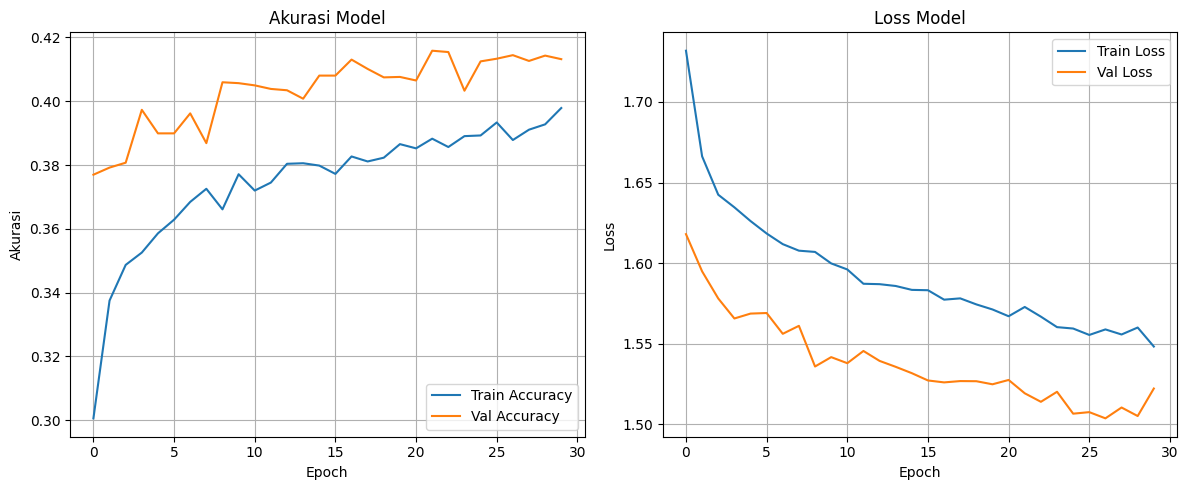

Found 7178 images belonging to 7 classes.
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step


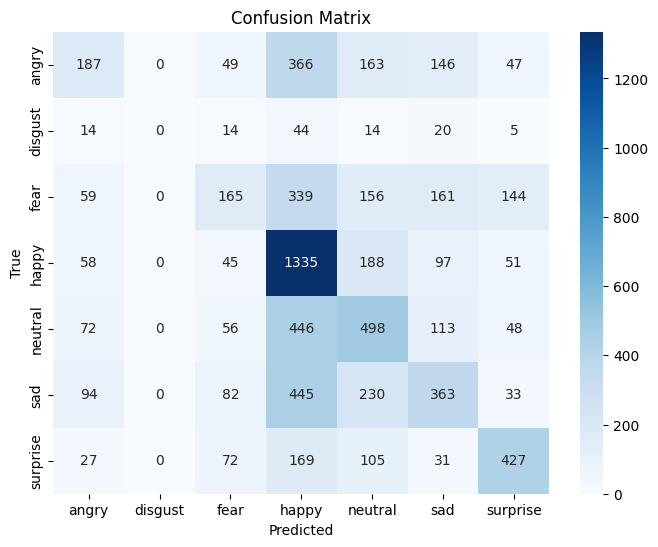


Classification Report:

              precision    recall  f1-score   support

       angry       0.37      0.20      0.25       958
     disgust       0.00      0.00      0.00       111
        fear       0.34      0.16      0.22      1024
       happy       0.42      0.75      0.54      1774
     neutral       0.37      0.40      0.39      1233
         sad       0.39      0.29      0.33      1247
    surprise       0.57      0.51      0.54       831

    accuracy                           0.41      7178
   macro avg       0.35      0.33      0.32      7178
weighted avg       0.40      0.41      0.39      7178



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Transfer Learning untuk Klasifikasi Ekspresi Emosi Wajah dengan VGG16

# 1. Import Library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# 2. Remove custom GrayscaleToRGBDataGenerator as ImageDataGenerator can handle color conversion
# class GrayscaleToRGBDataGenerator(ImageDataGenerator):
#     def standardize(self, x):
#         if x.shape[-1] == 1:
#             x = np.concatenate([x, x, x], axis=-1)
#         return super().standardize(x)

# 3. Path Dataset
train_dir = '/content/train'
val_dir = '/content/test' # Use test directory for validation as 'val' does not exist
test_dir = '/content/test'

# 4. ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='rgb', # Request RGB images
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(48, 48),
    color_mode='rgb', # Request RGB images
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# 5. Load Pretrained VGG16 Tanpa Top
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3))

# 6. Freeze layer VGG
for layer in vgg_base.layers:
    layer.trainable = False

# 7. Tambahkan classifier di atas VGG16
model = Sequential([
    # Remove the redundant Lambda layer for color conversion
    vgg_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 kelas emosi
])

# 8. Compile Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 9. Training with EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop]
)

# 10. Visualisasi Akurasi dan Loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# 11. Evaluasi di Data Test
test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='rgb', # Request RGB images
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
labels = list(test_generator.class_indices.keys())

# 12. Confusion Matrix dan Classification Report
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=labels))